## Monomial form of polynomial interpolation
__MATH 420__ <br>
_Section 3.1_ <br>
_Spring 2021_ <br>

Let's suppose we have a bunch of points in $\mathbf{R}^2$ that have _distinct_ first coordinates. Say the points are
$$
    (x_0, y_0),  (x_1, y_1), (x_2, y_2), \dots, (x_n, y_n).
$$
The subscripts start at zero and end with $n$, so we have $n+1$ points in $\mathbf{R}^2$.

We call the first coordinates of each point, that is $x_0, x_1, \dots, x_n$, the _knots._ Since the first coordinates are distinct, the points $(x_0, y_0)$ through $(x_n, y_n)$ are points on the graph of some function. The function _isn't_ unique, but let's try to find a function in the simplest class we can think of has these points on its graph. 

The simplest largish set of functions are the polynomials, so say we want to determine a polynomial $P$ that satisfies
$$
   P(x_0) = y_0, P(x_1) = y_1, \dots, P(x_n) = y_n.
$$
This is a very famous _interpolation problem._  The points $(x_0, y_0),  (x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)$ are called the _interpolation points._


Say our polynomial is
$$
   P(x) = c_0  + c_1 x + c_2 x^2 + \cdots + c_m x^m,
$$
where the coefficients $c_0$ through $c_m$ are to be determined. We have $n+1$ equations and $m+1$ coefficients, so we might _guess_ that we need $m = n.$ The condition $ P(x_0) = y_0$ gives
$$
   c_0 + c_1 x_0 + c_2 x_0^2 + c_3 x_0^3 + \cdots c_n x_0^n = y_0.
$$
Although this might look like a mess, it's really a linear equation for the unknowns $c_0$ through $c_n$. Using the remaining equations, that is,  $P(x_1) = y_1, \dots, P(x_n) = y_n$ and arranging the equations in matrix form gives
$$
  \begin{bmatrix} 1 & x_0 & x_0^2 & \cdots & x_0^n \\
                 1 & x_1 & x_1^2 & \cdots & x_1^n  \\
                 \vdots & \vdots & \vdots & \vdots \\
                  1 & x_n & x_n^2 & \cdots & x_n^n
   \end{bmatrix}  
   \begin{bmatrix}
       c_0 \\
       c_1 \\
       \vdots \\
       c_n
    \end{bmatrix} =  
     \begin{bmatrix}
       y_0 \\
       y_1 \\
       \vdots \\
       y_n
    \end{bmatrix}.
$$
Starting with a power of zero, each row of the coefficient matrix is an ascending list of powers of a knot. Any such matrix is a _Vandermonde_ matrix (https://en.wikipedia.org/wiki/Vandermonde_matrix). Unless the _Vandemonde_ matrix is singular (doesn't have an inverse), we've solved our problem. We'll soon prove that if the knots are distinct, a Vandermonde matrix has an inverse.


Let's look at an example.

In [1]:
using LinearAlgebra

Let's build a function that constructs a Vandermonde matrix from a collection of the knots. Our function is

In [2]:
"""
    vandermonde(x::Union{AbstractVector, Tuple})

Constructs a Vandermonde matrix given a vector or tuple `x`.

# Arguments
- `x::Union{AbstractVector, Tuple}`: A vector or tuple of input values.

# Returns
- `Matrix{eltype(x)}`: A Vandermonde matrix where the element at position (i, j)
  is `x[i]^(j-1)`
"""
function vandermonde(x::Union{AbstractVector, Tuple})
    n = length(x)
    V = Matrix{eltype(x)}(undef, n, n) 
    for i in 1 : n
      for j in 1 : n
        V[i, j] = x[i]^(j-1)
      end
    end
    V
end

vandermonde

Remember that for a real number $x$, Julia evaluates $x^0$ to $1$, even when $x$ is zero. Thus, our function should work OK even when one knot is zero.  

Say we want to find a polynomial whose graph contains the points
$$
  (0,1), (1, 4), (2, -3), (3, 107), (4, -46).
$$
The appropriate Vandermode matrix is

In [3]:
M = vandermonde((0,1,2,3,4))

5×5 Matrix{Int64}:
 1  0   0   0    0
 1  1   1   1    1
 1  2   4   8   16
 1  3   9  27   81
 1  4  16  64  256

To solve the interpolation problem, we only need to solve a linear system.

In [4]:
b = [1; 4; -3; 107; -46];

In [5]:
c = M \ b


5-element Vector{Float64}:
    1.0
  177.08333333333348
 -300.875
  147.91666666666666
  -21.125

Is this correct? Should we check? Of course, we should check. We would like to build a function that evaluates the polynomial $ x \mapsto c_0 + c_1 x + c_2 x^2 + \cdots + c_n x^n$.

Maybe we should use our polynomial evaluation code, but let's use a more Julia way:

In [6]:
P = x -> @evalpoly(x, c...)

#9 (generic function with 1 method)

The `(x, c...)` is a tricky Julia way to effectively do `(x, c_0, c_1, ... , c_n)`.

Mapping $P$ onto $(0,1,2,3,4)$ should give $(1,4,-3,107, -46)$. It does

In [7]:
map(P, (0,1,2,3,4))

(1.0, 4.000000000000142, -2.9999999999997726, 107.0000000000002, -46.0)

Actually, _every_ time we solve a linear system, we should check the condition number:

In [8]:
cond(M, Inf)

4546.666666666666

Compared to the machine epsilon, this isn't huge. Let's try G from GNAT. Looks like we are drinking from the fountain of success!

In [9]:
using Gadfly

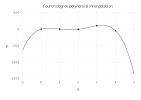

In [10]:
plot(layer(x = [0,1,2,3,4],y=[1,4,-3,107, -46],color=[colorant"black"]),
     layer(P, -1,5),color=[colorant"purple"], Guide.title("Fourth degree polynomial interpolation"))

Let's try another. This time, let's have lots of equally spaced knots that are _close_ together.

In [11]:
knots = [1.0 + k/100 for k = 0 : 10];

In [12]:
M = vandermonde(knots);

For the second coordinates of each point, let's use

In [13]:
y = [knots[i]^2 + 1 for i = 1 : 11, j=1:1];

OK--this is tricky our points are $(x_0, 1+x_0^2), (x_1, 1+ x_1^2), \dots $


So when we solve for the coefficients $c$, we expect $c[1] = 1, c[2] = 0, c[3] = 1$ and all addition values of $c$ to vanish. But that's _not_ what we get--the values differ greatly from these values. 

In [14]:
c = M \ y

11×1 Matrix{Float64}:
  1.030852384366234
 -0.21706841063949636
  1.5995770938088747
 -0.6786984456028677
 -0.28198765474438364
  1.9441251044282417
 -2.8351416048381677
  2.248657203948919
 -1.0559439881462565
  0.2771474109667239
 -0.03151909354782171

What's the story?  The condition number for $M$ is so huge, we shouldn't expect the solution to be accurate.

In [15]:
cond(M,Inf)

7.462438101488604e17

What about the residual? The residual is $M c = y$. It is

In [16]:
M * c - y

11×1 Matrix{Float64}:
  0.0
 -8.881784197001252e-16
  4.440892098500626e-16
  8.881784197001252e-16
  0.0
  0.0
 -4.440892098500626e-16
  0.0
 -4.440892098500626e-16
  8.881784197001252e-16
 -4.440892098500626e-16

The members of the residual are all comparable to the machine epsilon. So you might _think_ the solution is accurate, but the solution isn't accurate. Since the residual is small, graphically the solution very nearly goes through the interpolation points.

<div class="alert alert-block alert-warning"><b>Warning:</b> A small residual does not imply an accurate solution.</div>

In [17]:
PP = x -> @evalpoly(x, c...)

#15 (generic function with 1 method)

In [18]:
map(PP, knots) - y

11×1 Matrix{Float64}:
  0.0
 -4.440892098500626e-16
  1.3322676295501878e-15
  4.440892098500626e-16
  4.440892098500626e-16
  0.0
 -4.440892098500626e-16
  0.0
 -8.881784197001252e-16
  1.3322676295501878e-15
  0.0

In [19]:
QQ = x -> x^2 + 1

#17 (generic function with 1 method)

In [20]:
map(QQ, knots) - y

11×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Let's look at the graphs of both $PP$ and $QQ$. At least on the interval $[1,1.1]$, the functions $PP$ and $QQ$ are nearly identical.

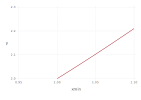

In [21]:
plot(layer(PP, 1,1.1,color=[colorant"purple"]), layer(QQ,1,1.1),color=[colorant"orange"])

A graph of their difference:

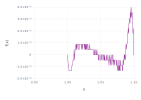

In [22]:
plot(x -> PP(x)-QQ(x),1,1.1,color=[colorant"purple"])

Outside the interval $[1,1.1]$, the functions are different.

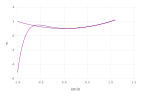

In [23]:
plot(layer(PP, -1,1.1), layer(QQ,-1,1.1),color=[colorant"purple"])

It's a bit mysterious, but although the condition number is huge, and we expect the solutions to be inaccurate, we get an interpolating polynomial that is visually accurate.

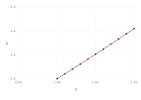

In [24]:
plot(layer(x = knots, y = y,color=[colorant"black"]),
     layer(PP,1, 1.1,color=[colorant"purple"]),
     layer(QQ,1, 1.1,color=[colorant"orange"]))

Both functions $PP$ and $QQ$ do a good job interpolating. But outside the range of the dots, the functions are far apart.

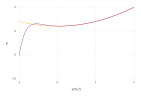

In [25]:
plot(#layer(x = knots, y = y,color=[colorant"black"]),
     layer(PP,-1, 2,color=[colorant"purple"]),
     layer(QQ,-1, 2,color=[colorant"orange"]))

Let's put all this together and build a function that returns a function that interpolates given points in the $\mathbf{R}^2$. 

Do we like to be careful? Of course, we do, so let's also return the matrix condition number as well as the interpolating polynomial. 

In [32]:
function interpolating_poly(pts)
    M = vandermonde(map(q -> q[1],pts))
    c = M \ map(q -> q[2],pts)
    q -> @evalpoly(q, c...), cond(M,Inf)
end    

interpolating_poly (generic function with 2 methods)

A simple test:

In [37]:
(fn,cnd) = interpolating_poly([[2,3],[5,6]])

(var"#23#26"{Vector{Float64}}([1.0, 1.0]), 13.999999999999998)

In [39]:
cnd

13.999999999999998

In [40]:
fn(2)

3.0

In [41]:
fn(5)

6.0